# Household Power Consumption ML Predictor

This notebook will focus on creating a ML model that aims to predict a household power consumption. This will also be the final project for the Machine Learning Algorithms course of IPCA - Aplied Machine Learning course. 

The project requirements paper is available in this repository under the name of "Practical_Assessment_MAAI_MLA_2025_2026.pdf".

Course professor [*lufer*](https://github.com/luferIPCA)

Notebook made by [*Álvaro Terroso*](https://github.com/alvaroterroso)

Dataset is available at [*UC Irvine*](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset public informations and import

This is a public dataset found on kaggle, the original authors are [*Georges Hébrail*](https://www.linkedin.com/in/georges-hebrail-582a0813/?originalSubdomain=fr) and [*Alice Bérard*](https://www.linkedin.com/in/aliceberard/). 

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010.

As the dataset is in txt format, we will need first to convert it to csv format.

In [2]:
# Import from the original TXT (semicolon-separated) and parse Date+Time
df = pd.read_csv(
	"household_power_consumption.txt",
	sep=";",
	na_values=["?", "NA", ""],
	parse_dates={"Datetime": ["Date", "Time"]}, # Merge Date and Time into Datetime
	infer_datetime_format=True, # Speed up parsing
	low_memory=False, # Avoid dtype warning
 	dayfirst=True # European date format
)

/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_29646/198833453.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_29646/198833453.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


## Dataset details

In [3]:
df.shape

(2075259, 8)

We got a data with 2 Million records, and 8 columns.

In [4]:
df.head(10)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


## Column meanings and purpose in the dataset

This dataset contains **minute-level electricity measurements** from a single household (Sceaux, France), collected over a long period (Dec 2006–Nov 2010). Each row is one timestamp, and the variables describe the household’s electrical load both at an overall level and for three specific appliance groups (sub-meterings). The dataset also contains a small proportion of missing measurements (~1.25%), meaning some timestamps exist but the sensor values may be absent.

### Datetime
- **Meaning:** The exact date and time of the measurement (one-minute resolution).
- **Purpose:** Enables time-series analysis and feature engineering (hour, day of week, seasonality, holidays), and supports forecasting (next minute/hour/day consumption).

### Global_active_power
- **Meaning:** Total **active power** consumed by the household at that minute (typically in **kW**).
- **Purpose:** This is usually the **main target variable** for forecasting/monitoring because it represents the real power used by appliances. It can also be converted into energy and cost estimates over time.

### Global_reactive_power
- **Meaning:** Total **reactive power** at that minute (typically in **kVAR**).
- **Purpose:** Helps characterize the type of electrical load (inductive/capacitive appliances). It can provide additional predictive signal and insight into efficiency/power quality, even though it is not “useful work” energy.

### Voltage
- **Meaning:** The household supply **voltage** at that minute (in **V**).
- **Purpose:** Captures grid/supply fluctuations that can affect current draw and power consumption. Useful for diagnosing abnormal behaviour and improving prediction accuracy.

### Global_intensity
- **Meaning:** Total **current intensity** drawn by the household at that minute (in **A**).
- **Purpose:** Another view of instantaneous load. Since power is related to voltage and current, this feature is strongly tied to consumption peaks and can help models detect high-load periods.

### Sub_metering_1
- **Meaning:** **Active energy** consumed by the **kitchen** appliance group during that minute (in **Wh**).
- **Purpose:** Provides appliance-group breakdown of consumption, supporting more detailed behavioural analysis (cooking patterns) and enabling models to learn which activities drive peaks.

### Sub_metering_2
- **Meaning:** **Active energy** consumed by the **laundry room** appliance group during that minute (in **Wh**).
- **Purpose:** Helps identify energy usage linked to washing/drying routines and supports targeted insights (e.g., shifting laundry to cheaper hours).

### Sub_metering_3
- **Meaning:** **Active energy** consumed by **electric water heating and air conditioning** during that minute (in **Wh**).
- **Purpose:** Often linked to strong **seasonal effects** (heating/cooling). It is key for analysing winter/summer consumption patterns and improving forecasting.


## Null values analysis

In [5]:
df.isnull().sum()

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

After this null assessment, we found that 25979 recorda are null.

Regarding the type of minute information the dataset provides us, and the fact that these records represent 1.25% of the dataset, they will be deleted.

In [6]:
# Drop rows with any null values
df = df.dropna().reset_index(drop=True)

# Quick check
df.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
df.isna().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
df.shape

(2049280, 8)

## Duplicated analysis

In [9]:
df.duplicated().sum()

0

This dataset has no duplicate data.

## Reduce dataframe
Currently the datataframe has registered values every minute. This explains the size amount and could introduce some noise during the training.

To correct this, we will convert the datafram to hourly registers.

In [10]:
# garantir datetime
df["Datetime"] = pd.to_datetime(df["Datetime"])

# ordenar e usar Datetime como índice
df = df.sort_values("Datetime").set_index("Datetime")

# converter potência (kW) em energia por minuto (kWh)
df["energy_kwh_min"] = df["Global_active_power"] / 60

# agregação por hora
hourly_df = df.resample("H").agg({
    "energy_kwh_min": "sum",          # TARGET (kWh por hora)
    "Global_reactive_power": "mean",
    "Voltage": "mean",
    "Global_intensity": "mean",
    "Sub_metering_1": "sum",
    "Sub_metering_2": "sum",
    "Sub_metering_3": "sum"
})

# renomear target
hourly_df = hourly_df.rename(columns={
    "energy_kwh_min": "target_kwh_hour"
})

# voltar a ter Datetime como coluna
hourly_df = hourly_df.reset_index()

hourly_df.head(10)


/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_29646/167088348.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample("H").agg({


,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0


In [11]:
hourly_df.shape

(34589, 8)

Now we got 34k records, which will give us plenty of information to work with.

## Create new features

For this project the goal is to predict the household energy consumption, and the dataset does not include some relevant features, such as **season**, **day of the week** or **if it is weekend**, among others.

For this stage, we will focus on creating categorical features for this, that in the future will be transformed to binary.

In [12]:
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

# create MM-DD format to compare using time intervals
md = hourly_df["Datetime"].dt.strftime("%m-%d")

hourly_df["season"] = np.select(
    [
        (md >= "03-20") & (md <= "06-20"),  # Spring
        (md >= "06-21") & (md <= "09-22"),  # Summer
        (md >= "09-23") & (md <= "12-20"),  # Fall
    ],
    ["spring", "summer", "fall"],
    default="winter"
)

# is_weekend
hourly_df["is_weekend"] = (hourly_df["Datetime"].dt.dayofweek >= 5).astype(int)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,season,is_weekend
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,fall,1
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,fall,1
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,fall,1
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,fall,1
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,fall,1
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,fall,1
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,fall,1
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,fall,1
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,fall,1
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,fall,1


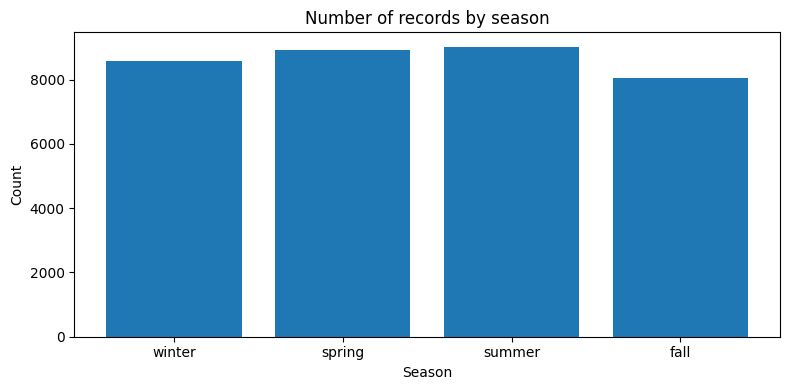

In [13]:
# Histogram / bar chart: records por estação
season_order = ["winter", "spring", "summer", "fall"]

season_counts = (
    hourly_df["season"]
    .astype(str)
    .value_counts()
    .reindex(season_order)
    .fillna(0)
)

plt.figure(figsize=(8, 4))
plt.bar(season_counts.index, season_counts.values)
plt.title("Number of records by season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We got a good, balance distributions of season.

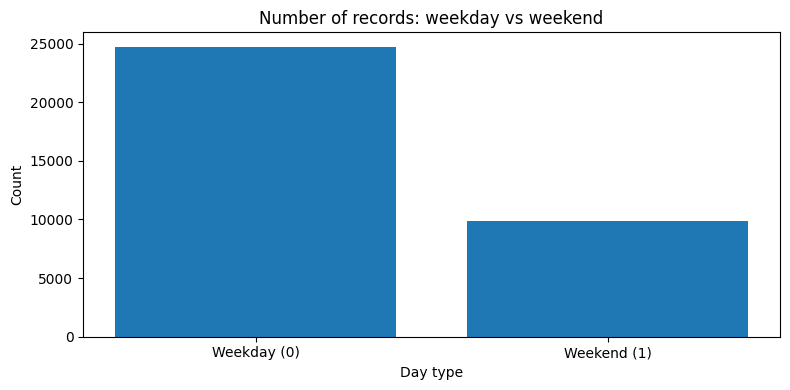

In [14]:
# Histogram / bar chart: semana vs fim de semana
weekend_counts = (
    hourly_df["is_weekend"]
    .value_counts()
    .reindex([0, 1])
    .fillna(0)
)

labels = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(8, 4))
plt.bar(labels, weekend_counts.values)
plt.title("Number of records: weekday vs weekend")
plt.xlabel("Day type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Has expected, the amount of weekdays is way bigger then the weekend amount.

In [15]:
# one-hot encoding (create season_spring, season_summer, season_fall, columns fall will be the default, but we will rename it)
hourly_df = pd.get_dummies(hourly_df, columns=["season"], prefix="season", drop_first=True)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,season_spring,season_summer,season_winter
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,1,False,False,False
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1,False,False,False
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1,False,False,False
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1,False,False,False
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1,False,False,False
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,1,False,False,False
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,1,False,False,False
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,1,False,False,False
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,1,False,False,False
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,1,False,False,False


We created 3 new binary features `season_spring`, `season_summer` and `season_winter`. `season_fall` does not exist because it is the default value (all other 3 are false)

## Training Split

In a time-series forecasting problem, the dataset should be split chronologically to avoid data leakage (training on future information). Besides the training and test sets, a validation set is useful because it allows us to choose the best model, features, and hyperparameters using only past data, without “tuning” decisions on the test set. This prevents overly optimistic results caused by repeatedly testing many configurations on the same test period. In practice, the validation set acts as a small “future-like” period inside the training window to check generalization before performing the final, unbiased evaluation on the held-out test set.


In [16]:
hourly_df = hourly_df.sort_values("Datetime").copy()
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

start = hourly_df["Datetime"].min()

# 2 anos e 6 meses para treino
train_end = start + pd.DateOffset(years=2, months=6)

# + 6 meses para validação (total 3 anos)
val_end = train_end + pd.DateOffset(months=6)

# resto para teste (deve dar ~9 meses no teu caso)
train2 = hourly_df[hourly_df["Datetime"] < train_end]
val    = hourly_df[(hourly_df["Datetime"] >= train_end) & (hourly_df["Datetime"] < val_end)]
test   = hourly_df[hourly_df["Datetime"] >= val_end]

print("Train period:", train2["Datetime"].min(), "->", train2["Datetime"].max(), "| n =", len(train2))
print("Val period:  ", val["Datetime"].min(),   "->", val["Datetime"].max(),   "| n =", len(val))
print("Test period: ", test["Datetime"].min(),  "->", test["Datetime"].max(),  "| n =", len(test))


# -------------------------
# 2) Features/target
# -------------------------
TARGET = "target_kwh_hour"

# Remover colunas que não devem ir como feature
# (Datetime nunca deve entrar como feature num modelo sklearn destes)
drop_cols = [TARGET, "Datetime"]

X_train = train2.drop(columns=[c for c in drop_cols if c in train2.columns]).copy()
y_train = train2[TARGET].copy()

X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns]).copy()
y_val   = val[TARGET].copy()

X_test  = test.drop(columns=[c for c in drop_cols if c in test.columns]).copy()
y_test  = test[TARGET].copy()

# garantir tudo numérico (bool -> 0/1)
X_train = X_train.astype(float)
X_val   = X_val.astype(float)
X_test  = X_test.astype(float)

Train period: 2006-12-16 17:00:00 -> 2009-06-16 16:00:00 | n = 21912
Val period:   2009-06-16 17:00:00 -> 2009-12-16 16:00:00 | n = 4392
Test period:  2009-12-16 17:00:00 -> 2010-11-26 21:00:00 | n = 8285


In [17]:
X_train.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,season_spring,season_summer,season_winter
0,0.229000,234.643889,18.100000,0.0,19.0,607.0,1.0,0.0,0.0,0.0
1,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1.0,0.0,0.0,0.0
2,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1.0,0.0,0.0,0.0
3,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1.0,0.0,0.0,0.0
4,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1.0,0.0,0.0,0.0


In [18]:
X_train.dtypes.value_counts()
X_train.select_dtypes(include=["object","datetime64[ns]"]).columns


Index([], dtype='object')

In [19]:
for c in hourly_df.columns:
    if hourly_df[c].dtype == "object":
        print(c, hourly_df[c].unique()[:10])

In [20]:
np.isinf(X_train.to_numpy()).sum(), np.isinf(X_val.to_numpy()).sum(), np.isinf(X_test.to_numpy()).sum()

(0, 0, 0)

In [21]:
hourly_df.isna().sum().sort_values(ascending=False).head(20)

Global_reactive_power    421
Voltage                  421
Global_intensity         421
Datetime                   0
target_kwh_hour            0
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64

In [22]:
print("NaNs train:", X_train.isna().sum().sort_values(ascending=False).head(15))
print("NaNs val:  ", X_val.isna().sum().sort_values(ascending=False).head(15))
print("NaNs test: ", X_test.isna().sum().sort_values(ascending=False).head(15))
# drop rows with NaNs (keep X/y aligned)
train_mask = ~X_train.isna().any(axis=1)
val_mask   = ~X_val.isna().any(axis=1)
test_mask  = ~X_test.isna().any(axis=1)

X_train, y_train = X_train.loc[train_mask].reset_index(drop=True), y_train.loc[train_mask].reset_index(drop=True)
X_val,   y_val   = X_val.loc[val_mask].reset_index(drop=True),     y_val.loc[val_mask].reset_index(drop=True)
X_test,  y_test  = X_test.loc[test_mask].reset_index(drop=True),   y_test.loc[test_mask].reset_index(drop=True)

print("After drop -> shapes:",
	"train", X_train.shape, y_train.shape,
	"| val", X_val.shape, y_val.shape,
	"| test", X_test.shape, y_test.shape)

print("NaNs train:", X_train.isna().sum().sort_values(ascending=False).head(15))
print("NaNs val:  ", X_val.isna().sum().sort_values(ascending=False).head(15))
print("NaNs test: ", X_test.isna().sum().sort_values(ascending=False).head(15))

NaNs train: Global_reactive_power    116
Voltage                  116
Global_intensity         116
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64
NaNs val:   Global_reactive_power    14
Voltage                  14
Global_intensity         14
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
is_weekend                0
season_spring             0
season_summer             0
season_winter             0
dtype: int64
NaNs test:  Global_reactive_power    291
Voltage                  291
Global_intensity         291
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64
After drop -> shapes: train (21796, 10) (21796,) | val (4378, 10)

The dataset cover 47 months, which translates to 3 years and 9 months. Regarding this we will select a train set size of 3 years and a test size of 9 months. We will split the test size in 84/16 for training and test validation, which corresponds to 2 years 6 months / 6 months

## Baseline model

For the purpose of this model, we want to make a predicition of energy consumption, regarding household eletric data. For this end, it is most suitable to use a regression model.
We will try 

## Models considered

As the goal of this model is to predict the energy consumption, we will assess the following regression models:
- Linear Regression
- Decision Tree Regression
- Random Forest Regression

In this phase, no single model is chosen a priori. We will train and evaluate the three previously selected regression models using the same data split, input features, and evaluation metrics. By comparing their results on the validation set, we can quantify performance differences and select the model that offers the best trade-off between accuracy and generalization.

Pre-trained models were not used. All models were trained from scratch using the training split of the provided dataset. However, we relied on pre-built algorithm implementations available in scikit-learn to ensure robustness, reproducibility, and a fair comparison between approaches. Implementing the models from scratch would significantly increase development time and the likelihood of implementation errors, while offering limited benefit for the scope of this practical work. The effort was therefore directed toward appropriate temporal splitting, feature engineering, and systematic evaluation.

Comment what we should do, and do it

In [ ]:
dfm = hourly_df.copy()
dfm["Datetime"] = pd.to_datetime(dfm["Datetime"])
dfm = dfm.sort_values("Datetime").set_index("Datetime")

# -------------------------
# 1) Features de calendário
# -------------------------
dfm["hour"]  = dfm.index.hour
dfm["dow"]   = dfm.index.dayofweek
dfm["month"] = dfm.index.month

# encoding cíclico (melhor que pôr hour=23 "longe" de hour=0)

dfm["hour_sin"]  = np.sin(2*np.pi*dfm["hour"]/24)
dfm["hour_cos"]  = np.cos(2*np.pi*dfm["hour"]/24)
dfm["dow_sin"]   = np.sin(2*np.pi*dfm["dow"]/7)
dfm["dow_cos"]   = np.cos(2*np.pi*dfm["dow"]/7)
dfm["month_sin"] = np.sin(2*np.pi*dfm["month"]/12)
dfm["month_cos"] = np.cos(2*np.pi*dfm["month"]/12)

# -------------------------
# 2) Lags do target (core!)
# -------------------------

lags = [1, 24, 168, 8736] # daily, weekly, yearly
for lag in lags:
    # Calcula o lag, mas se não existir, usa o valor do momento
    dfm[f"{TARGET}_lag_{lag}"] = dfm[TARGET].shift(lag)

    # Se o valor do lag for NaN (não existe no início), substitui pelo valor da própria hora
    dfm[f"{TARGET}_lag_{lag}"] = dfm[f"{TARGET}_lag_{lag}"].fillna(dfm[TARGET])


# -------------------------
# TESTEEEEEEE
# -------------------------

# 2) Rolling do target (sempre shift(1) antes!)
dfm[f"{TARGET}_roll_mean_3"]   = dfm[TARGET].shift(1).rolling(3).mean()
dfm[f"{TARGET}_roll_mean_24"]  = dfm[TARGET].shift(1).rolling(24).mean()
dfm[f"{TARGET}_roll_mean_168"] = dfm[TARGET].shift(1).rolling(168).mean()

# Rolling standard deviation
dfm[f"{TARGET}_roll_std_24"]   = dfm[TARGET].shift(1).rolling(24).std()
dfm[f"{TARGET}_roll_std_168"]  = dfm[TARGET].shift(1).rolling(168).std()

# -------------------------
# Substituir NaN com valor do momento
# -------------------------
dfm[f"{TARGET}_roll_mean_3"]   = dfm[f"{TARGET}_roll_mean_3"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_mean_24"]  = dfm[f"{TARGET}_roll_mean_24"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_mean_168"] = dfm[f"{TARGET}_roll_mean_168"].fillna(dfm[TARGET])

dfm[f"{TARGET}_roll_std_24"]   = dfm[f"{TARGET}_roll_std_24"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_std_168"]  = dfm[f"{TARGET}_roll_std_168"].fillna(dfm[TARGET])

sensor_cols = [
    "Global_reactive_power", "Voltage", "Global_intensity",
    "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]

'''
for col in sensor_cols:
    dfm[f"{col}_lag_1"]  = dfm[col].shift(1)
    dfm[f"{col}_lag_24"] = dfm[col].shift(24)
'''

# 4) Season: one-hot (se quiseres manter)

if "season" in dfm.columns:
    dfm = pd.get_dummies(dfm, columns=["season"], prefix="season", drop_first=True)

# -------------------------
# 5)
# remover as colunas "do momento" que causam nowcasting/leakage
# -------------------------

cols_to_drop_now = sensor_cols + ["hour", "dow", "month"]  # hour/dow/month já estão nos sin/cos
for c in cols_to_drop_now:
    if c in dfm.columns:
        dfm = dfm.drop(columns=c)

dfm.shape

(34589, 20)

In [24]:
dfm.head()

,target_kwh_hour,is_weekend,season_spring,season_summer,season_winter,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,target_kwh_hour_lag_1,target_kwh_hour_lag_24,target_kwh_hour_lag_168,target_kwh_hour_lag_8736,target_kwh_hour_roll_mean_3,target_kwh_hour_roll_mean_24,target_kwh_hour_roll_mean_168,target_kwh_hour_roll_std_24,target_kwh_hour_roll_std_168
Datetime,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,2.533733,1,False,False,False,-0.965926,-2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,2.533733,2.533733,2.533733,2.533733,2.533733,2.533733,2.533733,2.533733,2.533733
2006-12-16 18:00:00,3.632200,1,False,False,False,-1.000000,-1.836970e-16,-0.974928,-0.222521,-2.449294e-16,1.0,2.533733,3.632200,3.632200,3.632200,3.632200,3.632200,3.632200,3.632200,3.632200
2006-12-16 19:00:00,3.400233,1,False,False,False,-0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.632200,3.400233,3.400233,3.400233,3.400233,3.400233,3.400233,3.400233,3.400233
2006-12-16 20:00:00,3.268567,1,False,False,False,-0.866025,5.000000e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.400233,3.268567,3.268567,3.268567,3.188722,3.268567,3.268567,3.268567,3.268567
2006-12-16 21:00:00,3.056467,1,False,False,False,-0.707107,7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.268567,3.056467,3.056467,3.056467,3.433667,3.056467,3.056467,3.056467,3.056467


In [25]:
dfm.isna().sum().sort_values(ascending=False)

target_kwh_hour                  0
is_weekend                       0
target_kwh_hour_roll_std_24      0
target_kwh_hour_roll_mean_168    0
target_kwh_hour_roll_mean_24     0
target_kwh_hour_roll_mean_3      0
target_kwh_hour_lag_8736         0
target_kwh_hour_lag_168          0
target_kwh_hour_lag_24           0
target_kwh_hour_lag_1            0
month_cos                        0
month_sin                        0
dow_cos                          0
dow_sin                          0
hour_cos                         0
hour_sin                         0
season_winter                    0
season_summer                    0
season_spring                    0
target_kwh_hour_roll_std_168     0
dtype: int64

In [26]:
dfm.shape

(34589, 20)

In [27]:
y = dfm[TARGET].copy()
X = dfm.drop(columns=[TARGET]).copy()

X.dtypes.value_counts(), X.shape, y.shape

(float64    15
 bool        3
 int64       1
 Name: count, dtype: int64,
 (34589, 19),
 (34589,))

In [28]:
start = dfm.index.min()

train_end = start + pd.DateOffset(years=3, months=6)
val_end   = train_end + pd.DateOffset(months=1)

X_train = X[X.index < train_end]
y_train = y[y.index < train_end]

X_val   = X[(X.index >= train_end) & (X.index < val_end)]
y_val   = y[(y.index >= train_end) & (y.index < val_end)]

X_test  = X[X.index >= val_end]
y_test  = y[y.index >= val_end]

print("Train:", X_train.index.min(), "->", X_train.index.max(), "n=", len(X_train))
print("Val:  ", X_val.index.min(),   "->", X_val.index.max(),   "n=", len(X_val))
print("Test: ", X_test.index.min(),  "->", X_test.index.max(),  "n=", len(X_test))

Train: 2006-12-16 17:00:00 -> 2010-06-16 16:00:00 n= 30672
Val:   2010-06-16 17:00:00 -> 2010-07-16 16:00:00 n= 720
Test:  2010-07-16 17:00:00 -> 2010-11-26 21:00:00 n= 3197


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# baseline 1: persistência (prever igual à hora anterior)
pred_val_persist = X_val[f"{TARGET}_lag_1"]
print("Baseline persist | MAE:", mean_absolute_error(y_val, pred_val_persist),
      "| RMSE:", rmse(y_val, pred_val_persist))

# baseline 2: mesma hora do dia anterior
pred_val_day = X_val[f"{TARGET}_lag_24"]
print("Baseline day-ago | MAE:", mean_absolute_error(y_val, pred_val_day),
      "| RMSE:", rmse(y_val, pred_val_day))

Baseline persist | MAE: 0.3677958796296297 | RMSE: 0.5380083021856438
Baseline day-ago | MAE: 0.49571916666666677 | RMSE: 0.6867539784565693


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "HistGB": HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, max_iter=300, random_state=42
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)

    print(f"\n== {name} ==")
    print("VAL | MAE:", mean_absolute_error(y_val, pred_val),
          "| RMSE:", rmse(y_val, pred_val))


== LinearRegression ==
VAL | MAE: 0.3326722986675963 | RMSE: 0.46366124278938703

== HistGB ==
VAL | MAE: 0.32419102134998284 | RMSE: 0.45912539236010086

== RandomForest ==
VAL | MAE: 0.3258942294753086 | RMSE: 0.44924895799154446



sem mean, std, sum e delta

== LinearRegression ==
VAL | MAE: 0.3653972507122603 | RMSE: 0.5124662749150926

== HistGB ==
VAL | MAE: 0.3136171827370019 | RMSE: 0.4611126354978638

== RandomForest ==
VAL | MAE: 0.3333222336032183 | RMSE: 0.47665587657852415

In [31]:
val_df = pd.DataFrame({"y_true": y_val, "y_pred": models["HistGB"].predict(X_val)}, index=y_val.index)

monthly = val_df.resample("ME").sum()
monthly["abs_error_kwh"] = (monthly["y_pred"] - monthly["y_true"]).abs()
monthly["pct_error"] = monthly["abs_error_kwh"] / monthly["y_true"] * 100
monthly[["y_true","y_pred","abs_error_kwh","pct_error"]]

,y_true,y_pred,abs_error_kwh,pct_error
Datetime,,,,
2010-06-30,318.938967,314.752355,4.186612,1.312669
2010-07-31,314.152133,298.067178,16.084955,5.120117


junho de 2009 não deve entrar nesta análise, sendo que é um mês incompleto devido a muitos nulos

In [32]:
pred_persist = X_val["target_kwh_hour_lag_1"]
pred_dayago  = X_val["target_kwh_hour_lag_24"]
pred_weekago = X_val["target_kwh_hour_lag_168"]

print("Persist  | MAE:", mean_absolute_error(y_val, pred_persist), "| RMSE:", rmse(y_val, pred_persist))
print("Day-ago  | MAE:", mean_absolute_error(y_val, pred_dayago),  "| RMSE:", rmse(y_val, pred_dayago))
print("Week-ago | MAE:", mean_absolute_error(y_val, pred_weekago), "| RMSE:", rmse(y_val, pred_weekago))


Persist  | MAE: 0.3677958796296297 | RMSE: 0.5380083021856438
Day-ago  | MAE: 0.49571916666666677 | RMSE: 0.6867539784565693
Week-ago | MAE: 0.5283344907407408 | RMSE: 0.7251079563844526


meter mais lags, porque?
1) Transições dentro do dia (3h, 6h, 12h)
3h e 6h ajudam a modelar “subidas/descidas” típicas (fim da tarde → noite, manhã → almoço).
12h é muito útil porque:
consumo às 8h muitas vezes relaciona-se com o consumo às 20h (rotinas “simétricas” dia/noite)
ou pelo menos ajuda o modelo a perceber o “estado do dia”.
Sem estes lags, o modelo tem de inferir estas transições só com rolling means e calendário, o que nem sempre chega.
2) Memória de curto-médio prazo (48h, 72h)
48h = “mesma hora há 2 dias”
72h = “mesma hora há 3 dias”
Isto ajuda muito quando:
ontem foi um dia estranho (jantar fora, visita, ausência)
mas há 2/3 dias o padrão era mais “normal”
e o modelo consegue “não se agarrar” demasiado ao dia anterior.
Também ajuda a capturar padrões de “vários dias seguidos” (tipo férias, doença, trabalho remoto…).

Depois do teste não deram melhores resultados, até deram pior, assumimos que está a introduzir ruído ao modelo

iterative / recursive forecasting

In [33]:
import numpy as np
import pandas as pd

LAGS = [1,2,3,6,12,24,48,72,168]

def add_calendar_features(df):
    # df index datetime
    hour = df.index.hour
    dow  = df.index.dayofweek
    month= df.index.month

    df["hour_sin"]  = np.sin(2*np.pi*hour/24)
    df["hour_cos"]  = np.cos(2*np.pi*hour/24)
    df["dow_sin"]   = np.sin(2*np.pi*dow/7)
    df["dow_cos"]   = np.cos(2*np.pi*dow/7)
    df["month_sin"] = np.sin(2*np.pi*month/12)
    df["month_cos"] = np.cos(2*np.pi*month/12)
    df["is_weekend"] = (dow >= 5).astype(int)
    return df

def make_train_matrix(hourly_df, train_end):
    df = hourly_df.copy()
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").set_index("Datetime")

    # só até ao fim do treino
    df = df.loc[:train_end].copy()

    # mantém só target e (se quiseres) season/is_weekend já existente — mas calendar eu recomendo sin/cos
    df = df[[TARGET]].copy()

    # lags
    for lag in LAGS:
        df[f"{TARGET}_lag_{lag}"] = df[TARGET].shift(lag)

    # rolling (opcional; aqui funcionam bem)
    df[f"{TARGET}_roll_mean_24"]  = df[TARGET].shift(1).rolling(24).mean()
    df[f"{TARGET}_roll_mean_168"] = df[TARGET].shift(1).rolling(168).mean()
    df[f"{TARGET}_roll_std_24"]   = df[TARGET].shift(1).rolling(24).std()

    df = add_calendar_features(df)

    df = df.dropna()

    y = df[TARGET]
    X = df.drop(columns=[TARGET])
    return X, y

In [34]:
def forecast_month_recursive(model, hourly_df, train_end, month_start, month_end, feature_cols,
                             target="target_kwh_hour", lags=LAGS):

    df = hourly_df.copy()
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").set_index("Datetime")

    # histórico REAL até train_end
    history = df.loc[:train_end, target].copy()

    pred_index = pd.date_range(month_start, month_end, freq="h")
    preds = []

    for ts in pred_index:
        row = pd.DataFrame(index=[ts], columns=feature_cols, dtype=float)

        # ---- lags
        for lag in lags:
            col = f"{target}_lag_{lag}"
            if col in row.columns:
                t_lag = ts - pd.Timedelta(hours=lag)
                row[col] = history.loc[t_lag] if t_lag in history.index else np.nan

        # ---- rolling (usando janela até ts-1)
        # 24h
        if f"{target}_roll_mean_24" in row.columns or f"{target}_roll_std_24" in row.columns:
            w = history.loc[ts - pd.Timedelta(hours=24): ts - pd.Timedelta(hours=1)]
            if len(w) > 0:
                if f"{target}_roll_mean_24" in row.columns:
                    row[f"{target}_roll_mean_24"] = w.mean()
                if f"{target}_roll_std_24" in row.columns:
                    row[f"{target}_roll_std_24"] = w.std()
            else:
                if f"{target}_roll_mean_24" in row.columns:
                    row[f"{target}_roll_mean_24"] = np.nan
                if f"{target}_roll_std_24" in row.columns:
                    row[f"{target}_roll_std_24"] = np.nan

        # 168h
        if f"{target}_roll_mean_168" in row.columns:
            w = history.loc[ts - pd.Timedelta(hours=168): ts - pd.Timedelta(hours=1)]
            row[f"{target}_roll_mean_168"] = w.mean() if len(w) > 0 else np.nan

        # ---- calendário (tem de bater com o que meteste no treino)
        hour = ts.hour
        dow = ts.dayofweek
        month = ts.month

        if "hour_sin" in row.columns:  row["hour_sin"]  = np.sin(2*np.pi*hour/24)
        if "hour_cos" in row.columns:  row["hour_cos"]  = np.cos(2*np.pi*hour/24)
        if "dow_sin" in row.columns:   row["dow_sin"]   = np.sin(2*np.pi*dow/7)
        if "dow_cos" in row.columns:   row["dow_cos"]   = np.cos(2*np.pi*dow/7)
        if "month_sin" in row.columns: row["month_sin"] = np.sin(2*np.pi*month/12)
        if "month_cos" in row.columns: row["month_cos"] = np.cos(2*np.pi*month/12)
        if "is_weekend" in row.columns: row["is_weekend"] = int(dow >= 5)

        # segurança: se houver NaNs (buracos no histórico), preenche
        # (idealmente não devia acontecer se tens série horária completa)
        if row.isna().any().any():
            row = row.fillna(0)

        y_hat = float(model.predict(row)[0])
        preds.append(y_hat)

        # atualiza histórico com a previsão (isto é o "a seco")
        history.loc[ts] = y_hat

    return pd.Series(preds, index=pred_index, name="y_pred")


In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

def month_end(ts):
    return (ts + pd.offsets.MonthEnd(1)).normalize() + pd.Timedelta(hours=23)

def evaluate_dry_n_months(model, hourly_df, train_end, first_month_str, n_months, feature_cols, target="target_kwh_hour"):
    df = hourly_df.copy()
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").set_index("Datetime")

    start = pd.Timestamp(first_month_str + "-01 00:00:00")
    end = month_end(start + pd.DateOffset(months=n_months-1))

    # forecast contínuo (a seco) para todo o período
    y_pred = forecast_month_recursive(model, hourly_df, train_end, start, end, feature_cols, target=target)

    # truth
    y_true = df.loc[start:end, target]

    # tabela mensal
    pred_m = y_pred.resample("ME").sum()
    true_m = y_true.resample("ME").sum()

    monthly = pd.DataFrame({"y_true": true_m, "y_pred": pred_m})
    monthly["abs_error_kwh"] = (monthly["y_pred"] - monthly["y_true"]).abs()
    monthly["pct_error"] = monthly["abs_error_kwh"] / monthly["y_true"] * 100

    # métricas globais no período todo (hora a hora)
    overall = {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(rmse(y_true, y_pred)),
        "total_true_kwh": float(y_true.sum()),
        "total_pred_kwh": float(y_pred.sum()),
        "total_pct_error": float(abs(y_pred.sum()-y_true.sum())/y_true.sum()*100),
    }

    return monthly, overall, y_pred, y_true


In [36]:
# exemplo: treino até 2009-05-31 23:00, validação = Junho 2009 (se fosse completo) ou Julho 2009
train_end = pd.Timestamp("2009-05-31 23:00:00")
val_start = pd.Timestamp("2009-07-1 00:00:00")
val_end   = pd.Timestamp("2009-07-31 23:00:00")  # escolhe mês completo

X_train, y_train = make_train_matrix(hourly_df, train_end)
feature_cols = X_train.columns.tolist()

models["HistGB"].fit(X_train, y_train)


y_pred = forecast_month_recursive(models["HistGB"], hourly_df, train_end, val_start, val_end, feature_cols)

# ground truth real (só para avaliar)
df = hourly_df.copy()
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime").set_index("Datetime")
y_true = df.loc[val_start:val_end, TARGET]

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("DRY VAL | MAE:", mean_absolute_error(y_true, y_pred),
      "| RMSE:", rmse(y_true, y_pred))

true_month = y_true.sum()
pred_month = y_pred.sum()
print("Month true:", float(true_month), "Month pred:", float(pred_month),
      "Abs err:", float(abs(pred_month-true_month)),
      "Pct err:", float(abs(pred_month-true_month)/true_month*100))


DRY VAL | MAE: 0.43001346561358955 | RMSE: 0.5186042317789531
Month true: 459.84073333333333 Month pred: 551.444679267676 Abs err: 91.60394593434262 Pct err: 19.92079850567304


In [37]:
monthly_6, overall_6, y_pred_6, y_true_6 = evaluate_dry_n_months(
    models["HistGB"],
    hourly_df,
    train_end=train_end,
    first_month_str="2009-07",
    n_months=6,
    feature_cols=feature_cols,
    target="target_kwh_hour"
)

print(overall_6)
monthly_6

{'MAE': 0.5162559108515132, 'RMSE': 0.7143410052369573, 'total_true_kwh': 4439.279666666666, 'total_pred_kwh': 3976.434236634654, 'total_pct_error': 10.426138130187915}


,y_true,y_pred,abs_error_kwh,pct_error
2009-07-31,459.840733,551.444679,91.603946,19.920799
2009-08-31,484.606733,573.751553,89.144820,18.395291
2009-09-30,710.476067,554.929497,155.546569,21.893288
2009-10-31,851.478667,582.220594,269.258073,31.622410
2009-11-30,917.794033,667.208696,250.585337,27.303004
2009-12-31,1015.083433,1046.879217,31.795784,3.132332


problema atual, erro dá build up porque estamos a construir previsão sobre previsão

In [38]:
import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def month_range(month_str):  # "YYYY-MM"
    start = pd.Timestamp(month_str + "-01 00:00:00")
    end = (start + pd.offsets.MonthEnd(1)).normalize() + pd.Timedelta(hours=23)
    return start, end

def month_str_from_ts(ts):
    return f"{ts.year:04d}-{ts.month:02d}"

In [39]:
def walk_forward_dry_months(model_template, hourly_df, first_month_str, n_months, train_end,
                            target="target_kwh_hour"):
    """
    - train_end: timestamp final do treino antes do 1º mês (ex.: 2009-06-30 23:00 para prever 2009-07)
    - first_month_str: mês que queres prever primeiro (ex.: "2009-07")
    - n_months: quantos meses seguidos vais avaliar (ex.: 6 para Jul..Dez)
    """

    df2 = hourly_df.copy()
    df2["Datetime"] = pd.to_datetime(df2["Datetime"])
    df2 = df2.sort_values("Datetime").set_index("Datetime")

    results = []

    current_train_end = pd.Timestamp(train_end)

    # mês inicial
    m0_start, _ = month_range(first_month_str)

    for i in range(n_months):
        # mês a prever
        month_start = m0_start + pd.DateOffset(months=i)
        month_end = (month_start + pd.offsets.MonthEnd(1)).normalize() + pd.Timedelta(hours=23)
        month_str = month_str_from_ts(month_start)

        # 1) construir matriz de treino até current_train_end
        X_train, y_train = make_train_matrix(hourly_df, current_train_end)
        feature_cols = X_train.columns.tolist()

        # 2) treinar modelo novo (clone para não “carregar” estado)
        model = clone(model_template)
        model.fit(X_train, y_train)

        # 3) prever o mês inteiro A SECO (recursivo dentro do mês)
        y_pred = forecast_month_recursive(model, hourly_df, current_train_end,
                                          month_start, month_end, feature_cols,
                                          target=target)

        # 4) truth real para avaliar
        y_true = df2.loc[month_start:month_end, target]

        # métricas horárias
        mae = float(mean_absolute_error(y_true, y_pred))
        r = float(rmse(y_true, y_pred))

        # métricas mensais (total)
        true_sum = float(y_true.sum())
        pred_sum = float(y_pred.sum())
        abs_err = abs(pred_sum - true_sum)
        pct_err = (abs_err / true_sum) * 100 if true_sum > 0 else np.nan

        results.append({
            "month": month_str,
            "train_end": current_train_end,
            "MAE": mae,
            "RMSE": r,
            "month_true_kwh": true_sum,
            "month_pred_kwh": pred_sum,
            "abs_error_kwh": abs_err,
            "pct_error": pct_err,
        })

        # 5) “produção”: após o mês acontecer, o histórico real fica disponível
        # para o mês seguinte -> atualiza o train_end para o fim do mês atual
        current_train_end = month_end

    return pd.DataFrame(results)


In [40]:
df_results2 = walk_forward_dry_months(
    model_template=models["HistGB"],
    hourly_df=hourly_df,
    first_month_str="2009-07",
    n_months=6,
    train_end="2009-06-30 23:00:00",
    target="target_kwh_hour"
)

df_results2

,month,train_end,MAE,RMSE,month_true_kwh,month_pred_kwh,abs_error_kwh,pct_error
0,2009-07,2009-06-30 23:00:00,0.461630,0.560463,459.840733,655.174197,195.333464,42.478504
1,2009-08,2009-07-31 23:00:00,0.427464,0.544676,484.606733,598.477158,113.870424,23.497491
2,2009-09,2009-08-31 23:00:00,0.432317,0.580458,710.476067,853.501863,143.025796,20.130980
3,2009-10,2009-09-30 23:00:00,0.507258,0.689390,851.478667,1013.107530,161.628863,18.982139
4,2009-11,2009-10-31 23:00:00,0.500558,0.693567,917.794033,1021.998127,104.204093,11.353756
5,2009-12,2009-11-30 23:00:00,0.544273,0.766662,1015.083433,1024.514536,9.431103,0.929096


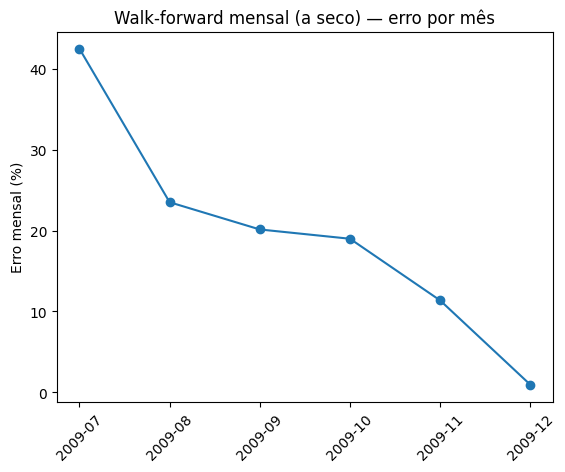

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results2["month"], df_results2["pct_error"], marker="o")
plt.xticks(rotation=45)
plt.ylabel("Erro mensal (%)")
plt.title("Walk-forward mensal (a seco) — erro por mês")
plt.show()